#### Bibliotecas

In [1]:
import requests
import json
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#### Extração dos Dados

API: Portal da Transparência do TCE SP (Tribunal de Contas do Estado de São Paulo)

Dados de despesas dos munícipios: Santos, Praia Grande, São Vicente, Guaruja, Caraguatatuba

In [2]:
#API municipios
url_municipios = 'https://transparencia.tce.sp.gov.br/api/json/municipios'

In [3]:
ret_municipio = requests.get(url_municipios)
municipio = json.loads(ret_municipio.content)


In [4]:
#Cria uma lista com todos os municípios que contêm dados de despesas disponíveis 
municipio_json = municipio
df_municipios = pd.DataFrame(municipio_json)
lista_municipios = df_municipios['municipio'].values.tolist()
mun_lista = lista_municipios


In [5]:
#Função para validar se os municípios escolhidos estão na lista do TCE
def valida_municipio(municipio=list, lista=list):
    for i in range(0, 5):
        if lista.index(municipio[i]):
            try:
                print(f"Município {municipio[i]} contêm dados de despesas disponíveis")
            except ValueError:
                print("O município não contém na lista")


In [6]:
municipios = ['santos', 'praia-grande', 'sao-vicente', 'guaruja', 'caraguatatuba']


In [7]:
municipios_validados = valida_municipio(municipios, mun_lista)


Município santos contêm dados de despesas disponíveis
Município praia-grande contêm dados de despesas disponíveis
Município sao-vicente contêm dados de despesas disponíveis
Município guaruja contêm dados de despesas disponíveis
Município caraguatatuba contêm dados de despesas disponíveis


In [9]:
#Função para criar dataframe pandas para cada município, consolidando todos os anos de 2014 a 2019
def df_despesa_municipio(municipio):

    url_despesas = 'https://transparencia.tce.sp.gov.br/api/json/despesas'
    municipio = municipio
    ano = [2014, 2015, 2016, 2017, 2018, 2019]
    mes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    lista_ano = list()
    df_despesas_unico = pd.DataFrame()


    for i_ano in ano:

        for i_mes in mes:
            retorno_api = f"{url_despesas}/{municipio}/{i_ano}/{i_mes}"
            retorno_despesas = requests.get(retorno_api)
            arquivo_despesas = json.loads(retorno_despesas.content)
            df_despesas_mes = pd.DataFrame(arquivo_despesas)
            df_despesas_unico = df_despesas_unico.append(df_despesas_mes, ignore_index=True)

        lista_ano.append(i_ano)

    print(f'Arquivo de Despesas criado com sucesso! \n Município: {municipio} \n Ano: {lista_ano} \n Mês: {mes}')

    return df_despesas_unico


### Transformação dos dados

In [10]:
def deleta_duplicidade(df_source):

    df = df_source.drop_duplicates()

    return df


In [11]:
def deleta_colunas(df_source):

    df = df_source.drop(columns=['evento', 'nr_empenho', 'id_fornecedor'])
    
    return df

In [12]:
def deleta_linha_vazia(df_source):

    df = df_source.dropna(how='all')

    return df

In [13]:
def rename_uppercase(df_source):

    lista = ['orgao', 'nm_fornecedor']

    for col in lista:
        df_source[col] = df_source[col].str.title()

    return df_source


In [14]:
def renomemar_coluna(df_source):

   df_source = df_source.rename(columns={'nm_fornecedor': 'nome_fornecedor', 'vl_despesa': 'valor_despesa'})

   return df_source   

In [51]:
def cria_nova_tabela_municipio(df_source, valor):

    df_source = df_source.assign(municipio=valor)

    df_source['dt_emissao_despesa'] = pd.to_datetime(
        df_source['dt_emissao_despesa'], format='%d/%m/%Y')
    
    df_source['ano'] = df_source['dt_emissao_despesa'].dt.year
    
    df_source = df_source.drop(
        columns=['orgao', 'nome_fornecedor', 'dt_emissao_despesa']
    )

    df_source = df_source.groupby(['municipio', 'ano', 'mes'])[
        'valor_despesa'].count().reset_index(name='valor_tota_despesa')
        
    df_source['valor_tota_despesa'] = df_source['valor_tota_despesa'].astype(float)


    return df_source


In [16]:
def cria_nova_tabela_orgaos(df_source):

    df_source['dt_emissao_despesa'] = pd.to_datetime(
        df_source['dt_emissao_despesa'], format='%d/%m/%Y')

    df_source['ano'] = df_source['dt_emissao_despesa'].dt.year

    df_source = df_source.drop(
        columns=['nome_fornecedor', 'dt_emissao_despesa'])

    df_source = df_source.groupby(['orgao', 'ano'])['valor_despesa'].count().reset_index(name='valor_tota_despesa')

    df_source['valor_tota_despesa'] = df_source['valor_tota_despesa'].astype(float)

    return df_source

#### Municipio de Praia Grande

In [ ]:
#Cria data frame
df_praia_grande = df_despesa_municipio('praia-grande')

In [18]:
#Chama as funções de transformação
df_mun_praia_grande = deleta_duplicidade(df_praia_grande)
df_mun_praia_grande = deleta_colunas(df_mun_praia_grande)
df_mun_praia_grande = deleta_linha_vazia(df_mun_praia_grande)
df_mun_praia_grande = rename_uppercase(df_mun_praia_grande)
df_mun_praia_grande = renomemar_coluna(df_mun_praia_grande)


In [52]:
#Cria novo dataframe visão despesa municipio por ano e mes
df_despesa_mun_praia_grande = cria_nova_tabela_municipio(df_mun_praia_grande, 'praia grande')

In [86]:
df_despesa_mun_praia_grande.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_mun_praia_grande.xlsx', index=False)

In [53]:
df_despesa_mun_praia_grande

,municipio,ano,mes,valor_tota_despesa
0,praia grande,2014,Abril,7065.0
1,praia grande,2014,Agosto,7658.0
2,praia grande,2014,Dezembro,9991.0
3,praia grande,2014,Fevereiro,5280.0
4,praia grande,2014,Janeiro,3671.0
...,...,...,...,...
67,praia grande,2019,Maio,7896.0
68,praia grande,2019,Março,5805.0
69,praia grande,2019,Novembro,8782.0
70,praia grande,2019,Outubro,9177.0


In [89]:
#Cria novo dataframe visão despesa orgao por ano 
df_despesa_orgaos_praia_grande = cria_nova_tabela_orgaos(df_mun_praia_grande)

In [90]:
df_despesa_orgaos_praia_grande.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_orgao_praia_grande.xlsx', index=False)

Gráfico 1 - Despesa total por ano 

In [29]:
#criando df somente com os campos necessários
df_grafico_praia_grande = df_despesa_mun_praia_grande.groupby(['ano'])['valor_despesa'].sum().reset_index(name='total')

#Criando lista com os valores das colunas
lista_ano_praia_grande = df_grafico_praia_grande['ano'].tolist()
lista_total_praia_grande = df_grafico_praia_grande['total'].tolist()

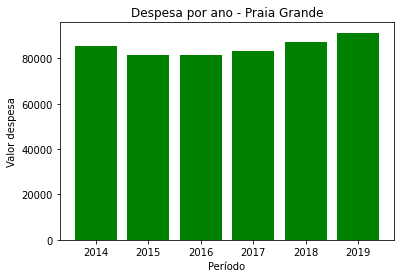

In [37]:
#gráfico com o valor de despesas por ano 
ano_praia_grande = lista_ano_praia_grande
despesa_praia_grande = lista_total_praia_grande

"""
    Chamamos o método bar que criará o gráfico de barra passando os 
    argumentos:
    - ano como eixo x
    - despasa como eixo y
    - color para as cores das barras como green
"""
plt.bar(ano_praia_grande, despesa_praia_grande, color="green")

#Legenda de cada barra eixo x
plt.xticks(ano_praia_grande)

#Label para eixo Y e X
plt.ylabel("Valor despesa")
plt.xlabel("Período")

#título do gráfico
plt.title("Despesa por ano - Praia Grande")

plt.show()

Gráfico 2 - valor de despesa total por orgão

In [62]:
df_grafico_orgao_pg = df_despesa_orgaos_praia_grande.groupby(['orgao'])['valor_tota_despesa'].sum().reset_index(name='total')

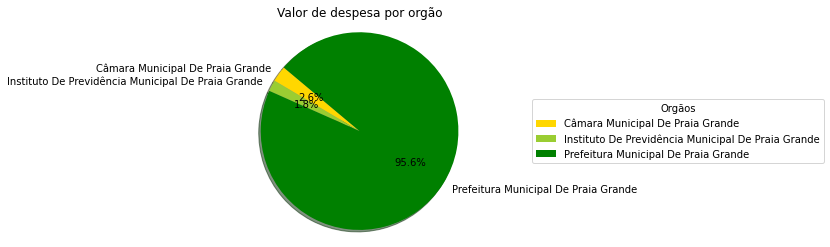

In [98]:
lista_orgao_pg = df_grafico_orgao_pg['orgao'].tolist()
lista_valor_despesa_pg = df_grafico_orgao_pg['total'].tolist()

#criando a área de plotagem
fig1, ax1 = plt.subplots()

#cores
colors = ['gold', 'yellowgreen', 'green']
#criando o gráfico
ax1.pie(lista_valor_despesa_pg, labels=lista_orgao_pg, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

#caixa de legenda externa
ax1.legend(lista_orgao_pg, 
          title='Orgãos', 
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))

#Título do gráfico
ax1.set_title("Valor de despesa por orgão")

#para deixar em círculo
ax1.axis('equal')

plt.show()

Gráfico 3 - valor de despesa da Prefeitura por ano

In [100]:
# Filtrando apenas o orgao prefeitura
df_filter_orgao_pg= df_despesa_orgaos_praia_grande[df_despesa_orgaos_praia_grande['orgao'] == "Prefeitura Municipal De Praia Grande"]

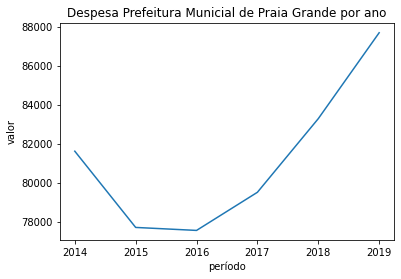

In [110]:
#Gráfico da despesa do orgao "Prefeitura Municipal De Praia Grande" por ano
x = df_filter_orgao_pg['ano'].tolist()
y = df_filter_orgao_pg['valor_tota_despesa'].tolist()

plt.plot(x, y) 
plt.xlabel("período")  
plt.ylabel("valor")  
plt.title("Despesa Prefeitura Municial de Praia Grande por ano")  
plt.show() 

#### Município Santos

In [ ]:
df_santos = df_despesa_municipio('santos')

In [22]:
#Chama as funções de transformação
df_mun_df_santos = deleta_duplicidade(df_santos)
df_mun_df_santos = deleta_colunas(df_mun_df_santos)
df_mun_df_santos = deleta_linha_vazia(df_mun_df_santos)
df_mun_df_santos = rename_uppercase(df_mun_df_santos)
df_mun_df_santos = renomemar_coluna(df_mun_df_santos)


In [54]:
#Cria novo dataframe visão despesa municipio por ano e mes
df_despesa_mun_santos = cria_nova_tabela_municipio(
    df_mun_df_santos, 'santos')

In [85]:
df_despesa_mun_santos.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_mun_santos.xlsx', index=False)

In [55]:
df_despesa_mun_santos

,municipio,ano,mes,valor_tota_despesa
0,santos,2014,Abril,9712.0
1,santos,2014,Agosto,10323.0
2,santos,2014,Dezembro,12790.0
3,santos,2014,Fevereiro,8577.0
4,santos,2014,Janeiro,8143.0
...,...,...,...,...
67,santos,2019,Maio,8378.0
68,santos,2019,Março,8194.0
69,santos,2019,Novembro,10023.0
70,santos,2019,Outubro,9363.0


In [25]:
#Cria novo dataframe visão despesa orgao por ano
df_despesa_orgaos_santos = cria_nova_tabela_orgaos(df_mun_df_santos)

In [84]:
df_despesa_orgaos_santos.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_orgao_santos.xlsx', index=False)

In [26]:
df_despesa_orgaos_santos

,orgao,ano,valor_tota_despesa
0,Caixa De Assistência Ao Servidor Público Munic...,2014,2256.0
1,Caixa De Assistência Ao Servidor Público Munic...,2015,2050.0
2,Caixa De Assistência Ao Servidor Público Munic...,2016,10306.0
3,Caixa De Assistência Ao Servidor Público Munic...,2017,9274.0
4,Caixa De Assistência Ao Servidor Público Munic...,2018,9067.0
5,Caixa De Assistência Ao Servidor Público Munic...,2019,9464.0
6,Câmara Municipal De Santos,2014,2195.0
7,Câmara Municipal De Santos,2015,2690.0
8,Câmara Municipal De Santos,2016,2393.0
9,Câmara Municipal De Santos,2017,2465.0


#### Município São Vicente

In [ ]:
df_sao_vicente = df_despesa_municipio('sao-vicente')

In [28]:
#Chama as funções de transformação
df_mun_df_sao_vicente = deleta_duplicidade(df_sao_vicente)
df_mun_df_sao_vicente = deleta_colunas(df_mun_df_sao_vicente)
df_mun_df_sao_vicente = deleta_linha_vazia(df_mun_df_sao_vicente)
df_mun_df_sao_vicente = rename_uppercase(df_mun_df_sao_vicente)
df_mun_df_sao_vicente = renomemar_coluna(df_mun_df_sao_vicente)


In [56]:
#Cria novo dataframe visão despesa municipio por ano e mes
df_despesa_mun_sao_vicente = cria_nova_tabela_municipio(
    df_mun_df_sao_vicente, 'sao vicente')


In [83]:
df_despesa_mun_sao_vicente.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_mun_sao_vicente.xlsx', index=False)

In [57]:
df_despesa_mun_sao_vicente

,municipio,ano,mes,valor_tota_despesa
0,sao vicente,2014,Abril,7218.0
1,sao vicente,2014,Agosto,6876.0
2,sao vicente,2014,Dezembro,10627.0
3,sao vicente,2014,Fevereiro,5570.0
4,sao vicente,2014,Janeiro,5968.0
...,...,...,...,...
67,sao vicente,2019,Maio,5488.0
68,sao vicente,2019,Março,4936.0
69,sao vicente,2019,Novembro,5700.0
70,sao vicente,2019,Outubro,5883.0


In [31]:
#Cria novo dataframe visão despesa orgao por ano
df_despesa_orgaos_sao_vicente = cria_nova_tabela_orgaos(df_mun_df_sao_vicente)

In [82]:
df_despesa_orgaos_sao_vicente.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_orgao_sao_vicente.xlsx', index=False)

#### Município Guarujá

In [ ]:
df_guaruja = df_despesa_municipio('guaruja')

In [34]:
#Chama as funções de transformação
df_mun_df_guaruja = deleta_duplicidade(df_guaruja)
df_mun_df_guaruja = deleta_colunas(df_mun_df_guaruja)
df_mun_df_guaruja = deleta_linha_vazia(df_mun_df_guaruja)
df_mun_df_guaruja = rename_uppercase(df_mun_df_guaruja)
df_mun_df_guaruja = renomemar_coluna(df_mun_df_guaruja)


In [58]:
#Cria novo dataframe visão despesa municipio por ano e mes
df_despesa_mun_guaruja = cria_nova_tabela_municipio(
    df_mun_df_guaruja, 'guaruja')


In [81]:
df_despesa_mun_guaruja.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_mun_guaruja.xlsx', index=False)

In [36]:
#Cria novo dataframe visão despesa orgao por ano
df_despesa_orgaos_guaruja = cria_nova_tabela_orgaos(df_mun_df_guaruja)


In [80]:
df_despesa_orgaos_guaruja.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\orgao_guaruja.xlsx', index=False)

#### Caraguatatuba

In [ ]:
df_caraguatatuba = df_despesa_municipio('caraguatatuba')


In [38]:
#Chama as funções de transformação
df_mun_caraguatatuba = deleta_duplicidade(df_caraguatatuba)
df_mun_caraguatatuba = deleta_colunas(df_mun_caraguatatuba)
df_mun_caraguatatuba = deleta_linha_vazia(df_mun_caraguatatuba)
df_mun_caraguatatuba = rename_uppercase(df_mun_caraguatatuba)
df_mun_caraguatatuba = renomemar_coluna(df_mun_caraguatatuba)


In [59]:
#Cria novo dataframe visão despesa municipio por ano e mes
df_despesa_mun_caraguatatuba = cria_nova_tabela_municipio(
    df_mun_caraguatatuba, 'caraguatatuba')


In [79]:
df_despesa_mun_caraguatatuba.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_mun_caraguatatuba.xlsx', index=False)

In [40]:
#Cria novo dataframe visão despesa orgao por ano
df_despesa_orgaos_caraguatatuba = cria_nova_tabela_orgaos(df_mun_caraguatatuba)


In [87]:
df_despesa_orgaos_caraguatatuba.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_orgao_caraguatatuba.xlsx', index=False)

Juntando os dataframes

In [ ]:
tabela_despesa_municipio = df_despesa_mun_praia_grande.append(
    [df_despesa_mun_santos, df_despesa_mun_sao_vicente, df_despesa_mun_guaruja, df_despesa_mun_caraguatatuba])


In [62]:
tabela_despesa_municipio


,municipio,ano,mes,valor_tota_despesa
0,praia grande,2014,Abril,7065.0
1,praia grande,2014,Agosto,7658.0
2,praia grande,2014,Dezembro,9991.0
3,praia grande,2014,Fevereiro,5280.0
4,praia grande,2014,Janeiro,3671.0
...,...,...,...,...
67,caraguatatuba,2019,Maio,8291.0
68,caraguatatuba,2019,Março,6901.0
69,caraguatatuba,2019,Novembro,7081.0
70,caraguatatuba,2019,Outubro,6675.0


In [77]:
tabela_despesa_municipio.to_excel(r'C:\Users\USER\Desktop\Projeto - TCE\tabelas\tabela_municipios.xlsx', index=False)

Gráfico 5 -  Despesa por município 

In [63]:
df_grafico_mun = tabela_despesa_municipio.groupby(['municipio'])['valor_tota_despesa'].sum().reset_index(name='total')

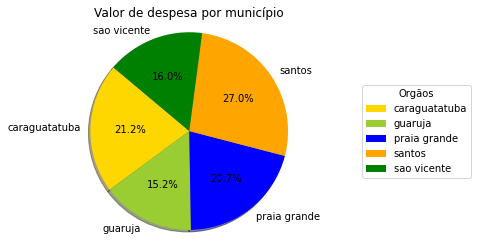

In [73]:
lista_mun = df_grafico_mun['municipio'].tolist()
lista_despesa= df_grafico_mun['total'].tolist()

#criando a área de plotagem
fig1, ax1 = plt.subplots()

#cores
colors = ['gold', 'yellowgreen', 'blue', 'orange', 'green']
#criando o gráfico
ax1.pie(lista_despesa, labels=lista_mun, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

#caixa de legenda externa
ax1.legend(lista_mun, 
          title='Orgãos', 
          loc='center left',
          bbox_to_anchor=(1, 0, 0.5, 1))

#Título do gráfico
ax1.set_title("Valor de despesa por município")

#para deixar em círculo
ax1.axis('equal')

plt.show()

Gráfico 6 - Despesa por município pelo período de 2014 a 2019 

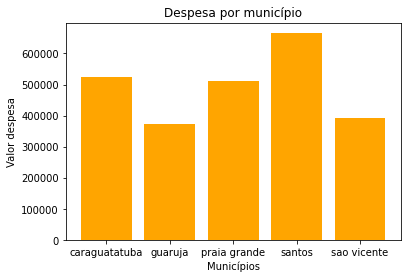

In [75]:
#gráfico com o valor de despesas por ano 
lista_mun_2 = df_grafico_mun['municipio'].tolist()
lista_despesa_2 = df_grafico_mun['total'].tolist()
"""
    Chamamos o método bar que criará o gráfico de barra passando os 
    argumentos:
    - ano como eixo x
    - despasa como eixo y
    - color para as cores das barras como green
"""
plt.bar(lista_mun_2, lista_despesa_2, color="orange")

#Legenda de cada barra eixo x
plt.xticks(lista_mun_2)

#Label para eixo Y e X
plt.ylabel("Valor despesa")
plt.xlabel("Municípios")

#título do gráfico
plt.title("Despesa por município")

plt.show()